### Basic Settings

In [14]:
import logging
import random

from nlp_practice.case.translation.data.dataloader import PairDataLoader
from nlp_practice.model.decoder import AttentionDecoderRNN, DecoderRNN
from nlp_practice.model.encoder import EncoderRNN
from nlp_practice.case.translation.training.trainer import Trainer
from nlp_practice.case.translation.Inference.predictor import Predictor
from nlp_practice.case.translation.data.preprocessor import Preprocessor
from nlp_practice.case.translation.evalution.evaluator import Evaluator

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger()

### Parameters

In [2]:
batch_size = 32
hidden_size = 128
dropout_rate = 0.1
num_epochs = 100
training_rate = 0.8
learning_rate = 0.0001
device = "cpu"
data_base_path = "../data"
first_language = "eng"
second_language = "fra" 
normal_checkpoint = "normal_seq2seq.pt"
attention_checkpoint = "attention_seq2seq.pt"

### Data Preprocessing

In [3]:
input_language, output_language, pairs = Preprocessor(
    base_path=data_base_path,
    first_language=first_language,
    second_language=second_language,
    does_reverse=True,
).process()

### Model Setup

In [4]:

encoder = EncoderRNN(
    input_size=input_language.num_words,
    hidden_size=hidden_size,
    dropout_rate=dropout_rate,
).to(device)


normal_decoder = DecoderRNN(
    hidden_size=hidden_size,
    output_size=output_language.num_words,
    dropout_rate=dropout_rate,
    device=device,
).to(device)

attention_decoder = AttentionDecoderRNN(
    hidden_size=hidden_size,
    output_size=output_language.num_words,
    dropout_rate=dropout_rate,
    device=device,
).to(device)


### Training Process

In [5]:
train_dataloader = PairDataLoader(
    pairs=pairs,
    input_language=input_language,
    output_language=output_language,
    training_rate=training_rate,
    batch_size=batch_size,
    device=device,
).train_dataloader

In [6]:
normal_trainer = Trainer(
    train_dataloader=train_dataloader,
    encoder=encoder,
    decoder=attention_decoder,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    logger=LOGGER,
)
normal_loss = normal_trainer.train()

100%|██████████| 100/100 [28:22<00:00, 17.02s/it]


In [7]:
attention_trainer = Trainer(
    train_dataloader=train_dataloader,
    encoder=encoder,
    decoder=attention_decoder,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    logger=LOGGER,
)
attention_loss = attention_trainer.train()



100%|██████████| 100/100 [29:31<00:00, 17.71s/it]


### Evaluation
#### Loss Comparasion

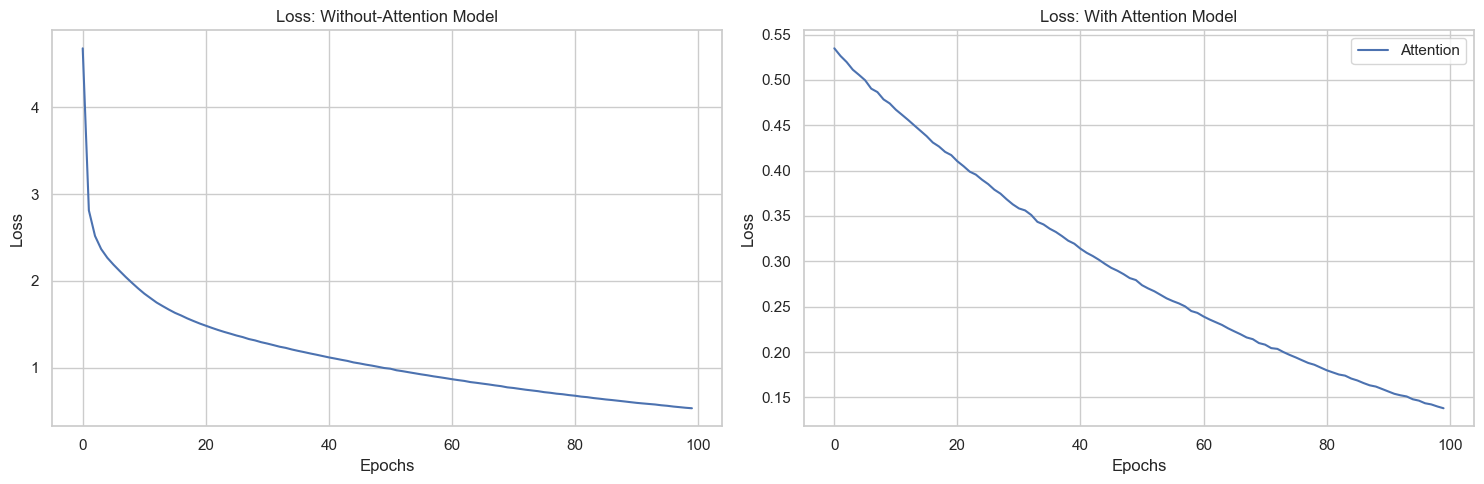

In [8]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(normal_loss, ax=axes[0])
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss: Without-Attention Model')

sns.lineplot(attention_loss, label='Attention', ax=axes[1])
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss: With Attention Model')
axes[1].legend()

plt.tight_layout()
plt.show()

#### Inference

In [11]:
normal_predictor = Predictor(encoder, normal_decoder, input_language, output_language)
attention_predictor = Predictor(encoder, attention_decoder, input_language, output_language)

In [12]:
input_sentence, answer = random.choice(pairs)
LOGGER.info(f"Translate {input_sentence!r} with the true sentence: {answer!r}")
LOGGER.info(f"Result with attention: {' '.join(normal_predictor.translate(input_sentence))!r}")
LOGGER.info(f"Result without attention: {' '.join(attention_predictor.translate(input_sentence))!r}")

INFO:root:Translate 'je suis retraitee' with the true sentence: 'i m retired'
INFO:root:Result with attention: 'cruel cool waste entrance choir workaholic dissatisfied loss spontaneous singer'
INFO:root:Result without attention: 'i m no doctor'


#### Metric Evaluation by the Test Dataset
- Metrics
   - Accuracy
   - [ROUGE-1](https://en.wikipedia.org/wiki/ROUGE_(metric))

In [31]:
test_dataloader = PairDataLoader(
    pairs=pairs,
    input_language=input_language,
    output_language=output_language,
    training_rate=training_rate,
    batch_size=batch_size,
    device=device,
).test_dataloader

normal_evaluator = Evaluator(test_dataloader, normal_predictor)
attention_evaluator = Evaluator(test_dataloader, attention_predictor)

result_pdf = pd.DataFrame.from_dict(
    {
        "model": ["Without-Attention", "With-Attention"],
        "accuracy": [normal_evaluator.accuracy, attention_evaluator.accuracy],
        "rouge-1-precision": [normal_evaluator.rouge1_precision, attention_evaluator.rouge1_precision],
        "rouge-1-recall": [normal_evaluator.rouge1_recall, attention_evaluator.rouge1_recall],
        "rouge-1-f1": [normal_evaluator.rouge1_f1, attention_evaluator.rouge1_f1],
    }
)
result_melted = pd.melt(result_pdf, id_vars="model", var_name="metric", value_name="value")

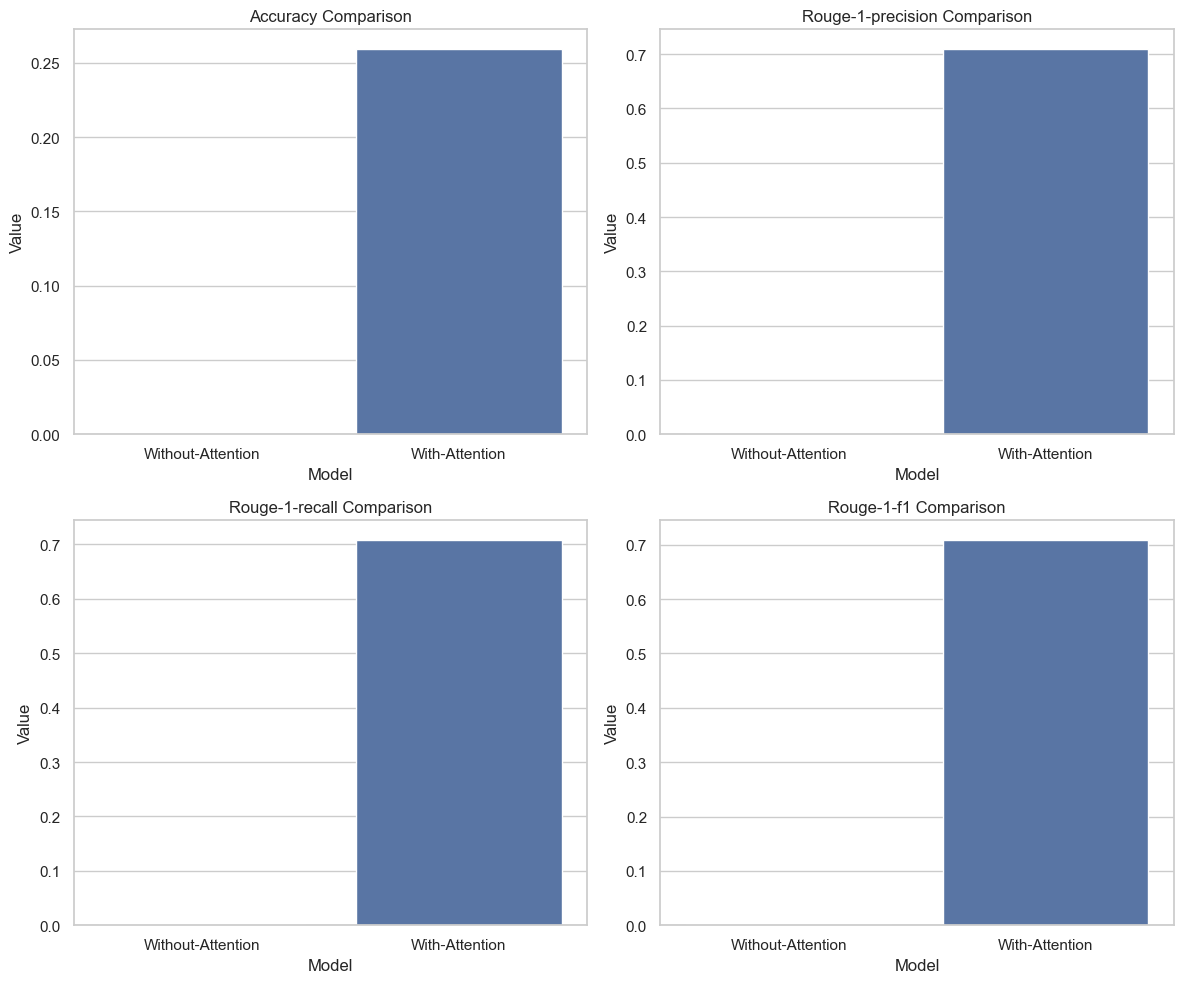

In [32]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

metrics = result_pdf.columns[1:]
for metric, ax in zip(metrics, axes.flatten()):
    sns.barplot(x="model", y="value", data=result_melted[result_melted["metric"] == metric], ax=ax)
    ax.set(title=f"{metric.capitalize()} Comparison", xlabel="Model", ylabel="Value")

plt.tight_layout()
plt.show()
